In [ ]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def load_dataset(folder_path, test_size=0.1):
  folders = ['train', 'test']
  sub_folders = ['pos', 'neg']

  X, Y = list(), list()
  
  for folder in folders:
    for sub_folder in sub_folders:
      path = os.path.join(folder_path, f"{folder}/{sub_folder}")
      files = os.listdir(path)
      print(f'Reading {len(files)} files in: {path}')
      for file_name in files:
        with open(os.path.join(path, file_name), 'r', encoding='utf-8') as f:
          text = f.read()
          
          X.append(text)
          if sub_folder == 'pos':
            Y.append(1)
          else:
            Y.append(0)
          
  X, Y = np.array(X), np.array(Y)
  X, X_test, Y, Y_test = train_test_split(X, Y, test_size=test_size, shuffle=True)
  
  return X, Y, X_test, Y_test

In [ ]:
path = "/content/aclImdb/"
X, Y, X_test, Y_test = load_dataset(folder_path=path, test_size=0.1)

Reading 12500 files in: /content/aclImdb/train/pos
Reading 12500 files in: /content/aclImdb/train/neg
Reading 12500 files in: /content/aclImdb/test/pos
Reading 12500 files in: /content/aclImdb/test/neg


In [ ]:
def preprocess_data(reviews):

  rep = {
    "<br />": " ", 
    "'ve": " have", 
    "'d": " would", 
    "don't": "do not", 
    "doesn't": "does not", 
    "did't": "did not", 
    "won't": "will not", 
    "can't": "cannot", 
    "should't": "should not", 
    "would't": "would not", 
    "isn't": "is not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "weren't": "were not",
    "wasn't": "was not", 
    "'ll": " will", 
    "'re": " are", 
    "it's": "it is",
    "It's": "it is", 
    "it´s": "it is",
    "he's": "he is", 
    "he’s": "he is",
    "she's": "she is", 
    "here's": "here is", 
    "i'm": "i am", 
    "they've": "they have", 
    "we've": "we have", 
    "That's": "that is", 
    "what's": "what is", 
    "what're": "what are", 
    "who's": "who is", 
    "that's": "that is", 
    "let\'s": "let us", 
    "c'mon": "come on", 
  }

  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  pattern = re.compile("|".join(rep.keys()))
  
  for index in range(len(reviews)):
    reviews[index] = pattern.sub(lambda m: rep[re.escape(m.group(0))], reviews[index])
    # reviews[index] = reviews[index].translate(str.maketrans('', '', string.punctuation))
    reviews[index] = re.sub(r'[^a-zA-Z]', ' ', reviews[index])
    reviews[index] = re.sub(r'\s+', ' ', reviews[index])
    
  return reviews

In [ ]:
X = preprocess_data(X)
X_test = preprocess_data(X_test)

TF-IDF Representation:

In [ ]:
vectorizer = TfidfVectorizer(min_df=2, max_features=30000)

texts = np.concatenate((X, X_test))
tokenized_texts = vectorizer.fit_transform(texts)
X, X_test = tokenized_texts[:len(X)], tokenized_texts[len(X):]

print(f'X.shape={X.shape}, X_test.shape={X_test.shape}')
features = vectorizer.get_feature_names_out()
print(f'features shape: {features.shape}')

X.shape=(45000, 30000), X_test.shape=(5000, 30000)
features shape: (30000,)


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

In [ ]:
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(36000, 30000) (9000, 30000) (36000,) (9000,)


# XGBoost

In [ ]:
xgb_classifier = xgb.XGBClassifier(max_depth=2, learning_rate=0.085, objective='binary:logistic', n_estimators = 5000, eval_metric = 'auc', min_child_weight=2, gamma=2)

In [ ]:
start_time = time.time()

xgb_classifier.fit(X, Y, eval_set=[(X_val, Y_val)])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Streaming output truncated to the last 5000 lines.
[1]	validation_0-auc:0.663049
[2]	validation_0-auc:0.6646
[3]	validation_0-auc:0.686833
[4]	validation_0-auc:0.727219
[5]	validation_0-auc:0.729154
[6]	validation_0-auc:0.741376
[7]	validation_0-auc:0.741807
[8]	validation_0-auc:0.743344
[9]	validation_0-auc:0.744093
[10]	validation_0-auc:0.743509
[11]	validation_0-auc:0.770419
[12]	validation_0-auc:0.772274
[13]	validation_0-auc:0.778404
[14]	validation_0-auc:0.784775
[15]	validation_0-auc:0.788892
[16]	validation_0-auc:0.794547
[17]	validation_0-auc:0.795861
[18]	validation_0-auc:0.796113
[19]	validation_0-auc:0.803512
[20]	validation_0-auc:0.806341
[21]	validation_0-auc:0.810942
[22]	validation_0-auc:0.811677
[23]	validation_0-auc:0.812648
[24]	validation_0-auc:0.815212
[25]	validation_0-auc:0.817465
[26]	validation_0-auc:0.819701
[27]	validation_0-auc:0.820498
[28]	validation_0-auc:0.821362
[29]	validation_0-auc:0.82371
[30]	validation_0-auc:0.825182
[31]	validation_0-auc:0.825974


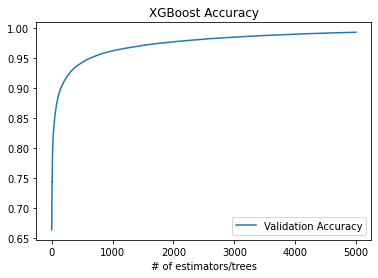

In [ ]:
xgb_val_acc = xgb_classifier.evals_result()['validaiton_1']['acc']

plt.figure()
plt.plot(xgb_val_acc, label='Validation Accuracy')
plt.title('XGBoost Accuracy')
plt.xlabel('# of estimators/trees')
plt.legend()
plt.show()

In [ ]:
preds = xgb_classifier.predict(X_test)
test_accuracy = accuracy_score(preds, Y_test)
print(f'Accuracy on the test set: {test_accuracy}')

Accuracy on the test set: 0.8902


In [ ]:
  xgb_classifier

XGBClassifier(eval_metric='auc', gamma=2, learning_rate=0.085, max_depth=2,
              min_child_weight=2, n_estimators=5000)

In [ ]:
xgb_classifier.save_model("xgbClassifier.json")

In [ ]:
# xgb_classifier = xgb.XGBClassifier(max_depth=2, learning_rate=0.085, objective='binary:logistic', n_estimators = 5000, eval_metric = 'auc', min_child_weight=2, gamma=2)
# Accuracy on the test set: 0.8842

In [ ]:
# xgb_classifier = xgb.XGBClassifier(max_depth=2, learning_rate=0.085, objective='binary:logistic', n_estimators = 1800, eval_metric = 'auc', min_child_weight=15, gamma=5)
# Accuracy on the test set: 0.8744

In [ ]:
# xgb_classifier = xgb.XGBClassifier(max_depth=2, learning_rate=0.085, objective='binary:logistic', n_estimators = 1500, eval_metric = 'auc', min_child_weight=20, gamma=10)
# Accuracy on the test set: 0.871

In [ ]:
# xgb_classifier = xgb.XGBClassifier(max_depth=2, learning_rate=0.085, objective='binary:logistic', n_estimators = 1500, eval_metric = 'auc', min_child_weight=20, gamma=10)
# Accuracy on the test set: 0.8644

In [ ]:
def xgb_predict_sentence(sentence):
  tokenized = vectorizer.transform([sentence])
  return xgb_classifier.predict(tokenized)

In [ ]:
xgb_predict_sentence('Completely lacking good taste, good senario, good ending!')

array([1])

In [ ]:
xgb_predict_sentence('Completely lacking good taste, good senario, good ending! What a waste of time!')

array([0])

# NGBoost

In [ ]:
!pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git

  Cloning https://github.com/stanfordmlgroup/ngboost.git to /tmp/pip-req-build-g7c5vbqk
  Running command git clone -q https://github.com/stanfordmlgroup/ngboost.git /tmp/pip-req-build-g7c5vbqk
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 348 kB 34.1 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
  Created wheel for ngboost: filename=ngboost-0.3.13.dev0-py3-none-any.whl size=31765 sha256=50ede4a8332fcf829151a88e9972d252e2787645af2969f2c5356900b7092055
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ye2tro1/wheels/9a/7f/a2/ce1d8e2bb0b0efd77e813f2311d132f536343daa6c8b5a81ee
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=694c9ffe3041c0aa099c013a03ed237d670e914abfc78a47ed7a208ac59fecfd
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successful

In [ ]:
from ngboost import NGBClassifier
from ngboost.distns import Normal, k_categorical, Bernoulli
from ngboost.scores import LogScore, CRPScore
from sklearn.tree import DecisionTreeRegressor

## NGBoost 800 estimators

In [ ]:
# learner = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
# b1 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
# b2 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=4)

# param_grid = {
#     'minibatch_frac': [1.0, 0.5],
#     'Base': [b1, b2]
# }

ngb = NGBClassifier(Dist=Bernoulli, Score=LogScore, 
                    n_estimators=800, learning_rate=0.085,
                    verbose=True)
                    # minibatch_frac=0.5, col_sample=0.5, verbose=False)

start_time = time.time()

ngb.fit(X_train, Y_train, X_val=X_val, Y_val=Y_val)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

[iter 0] loss=0.6931 val_loss=0.6672 scale=2.0000 norm=4.0000
[iter 100] loss=0.4193 val_loss=0.4400 scale=1.0000 norm=1.6811
[iter 200] loss=0.3889 val_loss=0.4251 scale=1.0000 norm=1.6597
[iter 300] loss=0.3820 val_loss=0.4236 scale=0.5000 norm=0.8289
[iter 400] loss=0.3741 val_loss=0.4222 scale=0.0039 norm=0.0065
[iter 500] loss=0.3702 val_loss=0.4219 scale=0.0005 norm=0.0008
[iter 600] loss=0.3695 val_loss=0.4220 scale=0.0010 norm=0.0016
[iter 700] loss=0.3690 val_loss=0.4220 scale=0.0005 norm=0.0008


NGBClassifier(learning_rate=0.085, n_estimators=800,
              random_state=RandomState(MT19937) at 0x7FEC8F501050)

In [ ]:
ngb_preds = ngb.predict(X_test)
print(ngb_preds.shape)

(5000,)


In [ ]:
ngb_test_accuracy = accuracy_score(ngb_preds, Y_test)
print(f'Accuracy on the test set: {ngb_test_accuracy}')

Accuracy on the test set: 0.8112


## NGBoost 2000 estimators

In [ ]:
ngb = NGBClassifier(Dist=Bernoulli, Score=LogScore, 
                    n_estimators=2000, learning_rate=0.085,
                    verbose=True)
                    # minibatch_frac=0.5, col_sample=0.5, verbose=False)
                    
start_time = time.time()

ngb.fit(X_train, Y_train, X_val=X_val, Y_val=Y_val)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

[iter 0] loss=0.6931 val_loss=0.6669 scale=2.0000 norm=4.0000
[iter 100] loss=0.4224 val_loss=0.4418 scale=1.0000 norm=1.6803
[iter 200] loss=0.3914 val_loss=0.4273 scale=1.0000 norm=1.6613
[iter 300] loss=0.3834 val_loss=0.4250 scale=0.0005 norm=0.0008
[iter 400] loss=0.3827 val_loss=0.4250 scale=0.5000 norm=0.8288
[iter 500] loss=0.3807 val_loss=0.4249 scale=0.0005 norm=0.0008
[iter 600] loss=0.3755 val_loss=0.4245 scale=0.0005 norm=0.0008
[iter 700] loss=0.3746 val_loss=0.4244 scale=0.0005 norm=0.0008
[iter 800] loss=0.3745 val_loss=0.4243 scale=0.0005 norm=0.0008
[iter 900] loss=0.3721 val_loss=0.4242 scale=0.0005 norm=0.0008
[iter 1000] loss=0.3719 val_loss=0.4242 scale=0.0005 norm=0.0008
[iter 1100] loss=0.3718 val_loss=0.4242 scale=1.0000 norm=1.6526
[iter 1200] loss=0.3692 val_loss=0.4242 scale=0.0005 norm=0.0008
[iter 1300] loss=0.3689 val_loss=0.4242 scale=0.0005 norm=0.0008
[iter 1400] loss=0.3688 val_loss=0.4242 scale=0.0005 norm=0.0008
[iter 1500] loss=0.3659 val_loss=0.42

NGBClassifier(learning_rate=0.085, n_estimators=2000,
              random_state=RandomState(MT19937) at 0x7F04C3A8A050)

In [ ]:
ngb_preds = ngb.predict(X_test)
print(ngb_preds.shape)

(5000,)


In [ ]:
ngb_test_accuracy = accuracy_score(ngb_preds, Y_test)
print(f'Accuracy on the test set: {ngb_test_accuracy}')

Accuracy on the test set: 0.8142


# Naive Bayes

tried to fit on the whole training data, but could not; faced memory limitations. Therefore, I trained using batches and fitting the naive bayes learner partially on each batch. 
<br>Learners:
* Gaussian.
* Bernoulli.
* Multinomial.
* Categorical.

In [ ]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, CategoricalNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [ ]:
def batch_nb(X, Y, X_test, Y_test, n, nb_learner):

  print(f'X shape: {X.shape}')
  splits=np.int(X.shape[0]/n)
  print(f'# of splits: {splits}')
  classes = np.unique(Y)
  print(f'classes: {classes}')
  nb = nb_learner()
  train_acc = 0.0
  n_times = 0

  for k in range(1, splits+1):
    data = []
    index = k*n
    if k == splits:
      # last split
      data = X[index:]
      output = Y[index:]
      print(f'last split: X: {data.shape}, Y: {output.shape}')
    elif k == 1:
      data = X[:index]
      output = Y[:index]
      print(f'first split k={k}, X: {data.shape}, Y: {output.shape}')
    else:
      previous_index = (k-1)*n
      data = X[previous_index:index]
      output = Y[previous_index:index]
      print(f'split k={k}, X: {data.shape}, Y: {output.shape}')
    if data.shape[0] > 0:
      nb.partial_fit(data.toarray(), output, classes=classes)
      c_train_acc = accuracy_score(nb.predict(data.toarray()) , output)
      train_acc += c_train_acc
      print(f'k={k}, train_acc: {c_train_acc}')
      n_times += 1

  train_acc = train_acc/n_times
  print(f'Training accuracy: {train_acc}')
  predictions = nb.predict(X_test.toarray())
  test_acc = accuracy_score(predictions , Y_test)
  print(f'Test accuracy: {test_acc}')
  return nb, train_acc, test_acc

In [ ]:
start_time = time.time()

gnb, gnb_train_acc, gnb_test_acc = batch_nb(X, Y, X_test, Y_test, 5000, GaussianNB)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

X shape: (45000, 30000)
# of splits: 9
classes: [0 1]
first split k=1, X: (5000, 30000), Y: (5000,)
k=1, train_acc: 0.9508
split k=2, X: (5000, 30000), Y: (5000,)
k=2, train_acc: 0.9122
split k=3, X: (5000, 30000), Y: (5000,)
k=3, train_acc: 0.9114
split k=4, X: (5000, 30000), Y: (5000,)
k=4, train_acc: 0.8806
split k=5, X: (5000, 30000), Y: (5000,)
k=5, train_acc: 0.881
split k=6, X: (5000, 30000), Y: (5000,)
k=6, train_acc: 0.87
split k=7, X: (5000, 30000), Y: (5000,)
k=7, train_acc: 0.861
split k=8, X: (5000, 30000), Y: (5000,)
k=8, train_acc: 0.8558
last split: X: (0, 30000), Y: (0,)
Training accuracy: 0.8903500000000001
Test accuracy: 0.71
Elapsed time: 0:0:38.6


In [ ]:
start_time = time.time()

bnb, bnb_train_acc, bnb_test_acc = batch_nb(X, Y, X_test, Y_test, 5000, BernoulliNB)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

X shape: (45000, 30000)
# of splits: 9
classes: [0 1]
first split k=1, X: (5000, 30000), Y: (5000,)
k=1, train_acc: 0.9378
split k=2, X: (5000, 30000), Y: (5000,)
k=2, train_acc: 0.9092
split k=3, X: (5000, 30000), Y: (5000,)
k=3, train_acc: 0.905
split k=4, X: (5000, 30000), Y: (5000,)
k=4, train_acc: 0.8926
split k=5, X: (5000, 30000), Y: (5000,)
k=5, train_acc: 0.8804
split k=6, X: (5000, 30000), Y: (5000,)
k=6, train_acc: 0.8784
split k=7, X: (5000, 30000), Y: (5000,)
k=7, train_acc: 0.8798
split k=8, X: (5000, 30000), Y: (5000,)
k=8, train_acc: 0.8838
last split: X: (0, 30000), Y: (0,)
Training accuracy: 0.895875
Test accuracy: 0.8502
Elapsed time: 0:0:28.0


In [ ]:
start_time = time.time()

mnb, mnb_train_acc, mnb_test_acc = batch_nb(X, Y, X_test, Y_test, 5000, MultinomialNB)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

X shape: (45000, 30000)
# of splits: 9
classes: [0 1]
first split k=1, X: (5000, 30000), Y: (5000,)
k=1, train_acc: 0.9452
split k=2, X: (5000, 30000), Y: (5000,)
k=2, train_acc: 0.9204
split k=3, X: (5000, 30000), Y: (5000,)
k=3, train_acc: 0.908
split k=4, X: (5000, 30000), Y: (5000,)
k=4, train_acc: 0.906
split k=5, X: (5000, 30000), Y: (5000,)
k=5, train_acc: 0.9032
split k=6, X: (5000, 30000), Y: (5000,)
k=6, train_acc: 0.8938
split k=7, X: (5000, 30000), Y: (5000,)
k=7, train_acc: 0.8894
split k=8, X: (5000, 30000), Y: (5000,)
k=8, train_acc: 0.8948
last split: X: (0, 30000), Y: (0,)
Training accuracy: 0.9076000000000001
Test accuracy: 0.8678
Elapsed time: 0:0:11.3


In [ ]:
start_time = time.time()

cnb, cnb_train_acc, cnb_test_acc = batch_nb(X, Y, X_test, Y_test, 5000, CategoricalNB)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

X shape: (45000, 30000)
# of splits: 9
classes: [0 1]
first split k=1, X: (5000, 30000), Y: (5000,)
k=1, train_acc: 0.5114
split k=2, X: (5000, 30000), Y: (5000,)
k=2, train_acc: 0.5006
split k=3, X: (5000, 30000), Y: (5000,)
k=3, train_acc: 0.5138
split k=4, X: (5000, 30000), Y: (5000,)
k=4, train_acc: 0.5064
split k=5, X: (5000, 30000), Y: (5000,)
k=5, train_acc: 0.4974
split k=6, X: (5000, 30000), Y: (5000,)
k=6, train_acc: 0.5062
split k=7, X: (5000, 30000), Y: (5000,)
k=7, train_acc: 0.5
split k=8, X: (5000, 30000), Y: (5000,)
k=8, train_acc: 0.5086
last split: X: (0, 30000), Y: (0,)
Training accuracy: 0.50555
Test accuracy: 0.4992
Elapsed time: 0:3:5.9


# Logistic Regression
Logistic regression with K-Fold Cross Validation *(K=10 bins)* <br>
Did not converge at first using the default maximum number of iteration which was 200, I increased it to 500, and it didn't converge either, finally, I increased it to 1000 iterations, and it eventually converged.
Training accuracy was 95% and testing accuracy was 90%.
I used `lbfgs` optimization algorithm which uses L2 regularization which is normally used with multinomial problems.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
start_time = time.time()

lr = LogisticRegressionCV(cv=10, max_iter=1000)
lr.fit(X, Y)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:16:24.4


In [ ]:
lr.score(X,Y)

0.9505111111111111

In [ ]:
lr.score(X_test,Y_test)

0.9012

Then used `liblinear` which is a simpler algorithm, normally used for small datasets, but it's faster to train. It supports  both `L1` and `L2` regularization, but I'm going to stick with `L2` because it's has shown good empirical results. Achieved similar results to the previous one.

In [ ]:
start_time = time.time()

lr_liblinear = LogisticRegressionCV(cv=10, max_iter=1000, solver='liblinear')
lr_liblinear.fit(X, Y)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:7:4.0


In [ ]:
lr_liblinear.score(X,Y)

0.9504888888888889

In [ ]:
lr_liblinear.score(X_test,Y_test)

0.9012

Then tried:
`saga`
and 
`newton-cg`

In [ ]:
start_time = time.time()

lr_saga = LogisticRegressionCV(cv=10, max_iter=1000, solver='saga')
lr_saga.fit(X, Y)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Elapsed time: 0:31:31.3


In [ ]:
lr_saga.score(X,Y)

0.9505111111111111

In [ ]:
lr_saga.score(X_test,Y_test)

0.9012

In [ ]:
start_time = time.time()

lr_newtoncg = LogisticRegressionCV(cv=10, max_iter=1000, solver='newton-cg')
lr_newtoncg.fit(X, Y)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:7:38.1


In [ ]:
lr_newtoncg.score(X,Y)

0.9505111111111111

In [ ]:
lr_newtoncg.score(X_test,Y_test)

0.9012

# Decision Trees

In [ ]:
from sklearn import tree

In [ ]:
clf = tree.DecisionTreeClassifier()

start_time = time.time()

clf.fit(X, Y)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:2:12.4


In [ ]:
clf.score(X,Y)

1.0

In [ ]:
clf.score(X_test,Y_test)

0.714

# Random Forest

* Started with 100 estimators (trees; weak learners), criterion: `gini`
* 100 estimators, criterion: `entropy`


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df1 = RandomForestClassifier()

start_time = time.time()

df1.fit(X, Y)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:3:10.5


In [ ]:
df1.score(X, Y)

1.0

In [ ]:
df1.score(X_test, Y_test)

0.848

In [ ]:
df2 = RandomForestClassifier(criterion='entropy')

start_time = time.time()

df2.fit(X, Y)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:3:8.2


In [ ]:
df2.score(X, Y)

1.0

In [ ]:
df2.score(X_test, Y_test)

0.8394

# SVM

In [ ]:
from sklearn import svm

In [ ]:
svc_linear = svm.SVC(kernel='linear')

start_time = time.time()

svc_linear.fit(X, Y)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:43:27.8


In [ ]:
svc_linear.score(X, Y)

0.9524222222222222

In [ ]:
svc_linear.score(X_test, Y_test)

0.8988

In [ ]:
svc_rbf = svm.SVC(kernel='rbf')

start_time = time.time()

svc_rbf.fit(X, Y)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 1:23:41.7


In [ ]:
svc_rbf.score(X, Y)

0.9868444444444444

In [ ]:
svc_rbf.score(X_test, Y_test)

0.9046

# Thank you!